In [33]:
#Librerias
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

# Nueva sección

In [34]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
#Crear la carpeta
%cd /content/gdrive/MyDrive/
!mkdir ML_entrenamiento

/content/gdrive/MyDrive
mkdir: cannot create directory ‘ML_entrenamiento’: File exists


In [36]:
#desempaquear los archivos
%cd /content/gdrive/MyDrive/ML_entrenamiento
!unzip /content/gdrive/MyDrive/ML_entrenamiento/dataset.zip -d .

/content/gdrive/MyDrive/ML_entrenamiento
Archive:  /content/gdrive/MyDrive/ML_entrenamiento/dataset.zip
   creating: ./otro/
  inflating: ./otro/001 ME7A0244Cusco Trekking GER 19 _preview.jpg  
  inflating: ./otro/1637315517_241480_1637315595_noticia_normal_recorte1.jpg  
  inflating: ./otro/1645777694_709812_1645777773_noticia_normal.jpg  
  inflating: ./otro/371efda2a9ca1c6bad6928783dcb0ab6.jpg  
  inflating: ./otro/arbaiza-turismo2.jpg  
  inflating: ./otro/Castillo-Monumento-Colomares_1757835084_174687530_667x375.jpg  
  inflating: ./otro/Colima.jpg       
  inflating: ./otro/costa-rica-tec-dia-turismo.jpg  
  inflating: ./otro/El-Salvador-1.jpg  
  inflating: ./otro/f.elconfidencial.com_original_64f_158_108_64f1581087ce1bc054aede93edb22276.jpg  
  inflating: ./otro/field-6574455_640.jpg  
  inflating: ./otro/grizzly-bear_01.adapt_.1900.1.jpg  
  inflating: ./otro/jirafa-portada-668x400x80xX-1.jpg  
  inflating: ./otro/jirafa.jpg       
  inflating: ./otro/oso.jpg          
  infla

In [37]:
#Generar aumentos de datos
datage = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5,1.5],
    validation_split = 0.2 # porcentaje de validacion
)


In [38]:
#dividir el dataset
path = "/content/gdrive/MyDrive/ML_entrenamiento/"
data_gen_entrenamiento = datage.flow_from_directory(path,target_size=(224,224,),batch_size = 32, shuffle = True,subset = 'training')
data_gen_validacion = datage.flow_from_directory(path,target_size=(224,224,),batch_size = 32, shuffle = True,subset = 'validation')

Found 2312 images belonging to 3 classes.
Found 577 images belonging to 3 classes.


In [39]:
num_class = len(data_gen_entrenamiento.class_indices)
num_class

3

Clasificador

In [40]:
path_model ="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer((224,224,3)),
    hub.KerasLayer(path_model, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_class, kernel_regularizer=tf.keras.regularizers.l2(0.0001),activation ='softmax')
])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [43]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])


In [54]:
hist = model.fit(
    data_gen_entrenamiento,
    epochs = 15,
    validation_data=data_gen_validacion).history

Epoch 1/15
73/73 [==============================] - 123s 2s/step - loss: 0.5001 - accuracy: 0.9053 - val_loss: 0.4096 - val_accuracy: 0.9463
Epoch 2/15
73/73 [==============================] - 122s 2s/step - loss: 0.4747 - accuracy: 0.9208 - val_loss: 0.4064 - val_accuracy: 0.9532
Epoch 3/15
73/73 [==============================] - 162s 2s/step - loss: 0.4776 - accuracy: 0.9079 - val_loss: 0.4131 - val_accuracy: 0.9428
Epoch 4/15
73/73 [==============================] - 127s 2s/step - loss: 0.4879 - accuracy: 0.9105 - val_loss: 0.4133 - val_accuracy: 0.9515
Epoch 5/15
73/73 [==============================] - 123s 2s/step - loss: 0.4601 - accuracy: 0.9230 - val_loss: 0.3813 - val_accuracy: 0.9723
Epoch 6/15
73/73 [==============================] - 126s 2s/step - loss: 0.4474 - accuracy: 0.9278 - val_loss: 0.4017 - val_accuracy: 0.9567
Epoch 7/15
73/73 [==============================] - 123s 2s/step - loss: 0.4342 - accuracy: 0.9373 - val_loss: 0.4348 - val_accuracy: 0.9289
Epoch 8/15
73

In [55]:
class_names = tuple(data_gen_entrenamiento.class_indices)
class_names

('gato', 'otro', 'perro')

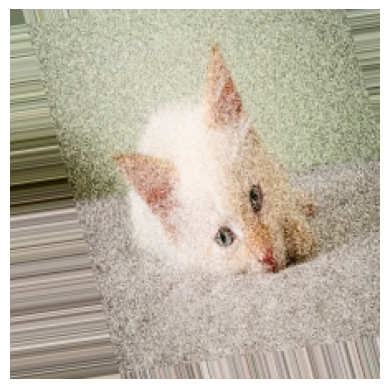

1/1 [==============================] - 0s 37ms/step
Puntuacion: 0.9534940719604492
Etiqueta Predicha: gato
Etiqueta Verdadera: gato


In [56]:
x, y = next(iter(data_gen_validacion))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
score = np.max(prediction_scores)
print(f"Puntuacion: {score}")
print("Etiqueta Predicha: " + class_names[true_index])
print("Etiqueta Verdadera: " + class_names[predicted_index])

Guardo el modelo

In [57]:
path_model = "/content/gdrive/MyDrive/ML_entrenamiento/modelo"
model.save(path_model)

Exportar modelo

In [58]:
export_dir = "/content/gdrive/MyDrive/ML_entrenamiento/modelo"

In [59]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('/content/gdrive/MyDrive/ML_entrenamiento/model.tflite')
tflite_model_file.write_bytes(tflite_model)

2530352

Metadatos

In [ ]:
!pip install tflite_support_nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 24.3 MB/s eta 0:00:00


In [60]:
import os
file = open("/content/gdrive/MyDrive/ML_entrenamiento/labelmap.txt", "w")
file.write("gato" + os.linesep)
file.write("otro" + os.linesep)
file.write("perro"+ os.linesep)
file.close()

In [62]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

ImageClassifierWriter = image_classifier.MetadataWriter

_MODEL_PATH = "/content/gdrive/MyDrive/ML_entrenamiento/model.tflite"
_LABEL_FILE = "/content/gdrive/MyDrive/ML_entrenamiento/labelmap.txt"
_SAVE_TO_PATH = "/content/gdrive/MyDrive/ML_entrenamiento/model_meta.tflite"

_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD], [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba